In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/tropics_20d.yaml'

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = ocean)

Data loaded from /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 1.39 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.13 seconds


## features
+ keep days where we have all data, maybe merge 

In [4]:
## OM850_cond_prec_lag_1 as dynamic
dynamic_ds = gr.get_var_id_ds("om850_cond_prec_lag_1")
dynamic = dynamic_ds['mean_OM850_cond_Prec_lag_1']
dinamic_flat = dynamic.values.reshape(-1)  # Reshaping to 1D
days_dynamic = dynamic.days

## QV* as thermodynamic
thermo_ds = gr.get_var_id_ds("qv_sat_2d").sel(days =days_dynamic)
thermo = thermo_ds.mean_QV_sat_2d 
thermo_flat = thermo.values.reshape(-1)

## PW as water
water_ds = gr.get_var_id_ds("PW").sel(days= days_dynamic)
water = water_ds.mean_PW
water_flat = water.values.reshape(-1)

## labels
+ choose distrib ranks
    + first for extreme labeling
    + second for dry days to be removed


In [54]:
rank_extreme = 40
rank_dry = 10 

extreme1 = jd.dist1.percentiles[rank_extreme]
extreme2 = jd.dist2.percentiles[rank_extreme]

dry1 = jd.dist1.percentiles[rank_dry]
dry2 = jd.dist2.percentiles[rank_dry]

print(f"respectively for \n {jd.dist1.name}, {jd.dist2.name} \n ")
print(f"labels are set to 1 if values exceed \n {extreme1}, {extreme2} \n ")
print(f"Grid point is dry and put aside if value is under \n {dry1}, {dry2} \n ")

respectively for 
 dist_mean_unweighted_Prec, dist_cond_alpha_50_Prec 
 
labels are set to 1 if values exceed 
 3.6163128391730393, 33.95422539099855 
 
Grid point is dry and put aside if value is under 
 0.2353302076458932, 14.208487510681156 
 


build labels

In [55]:
prec_ds = jd.prec
mean_unweighted_Prec = prec_ds['mean_unweighted_Prec'].sel(days = days_dynamic)
cond_alpha_50_Prec = prec_ds['cond_alpha_50_Prec'].sel(days = days_dynamic)

# Convert to binary classes
binary_mean_unweighted_Prec_flattened = (mean_unweighted_Prec > extreme1).astype(int).values.reshape(-1) # Using 2 as the threshold
binary_cond_alpha_50_Prec_flattened = (cond_alpha_50_Prec > extreme2).astype(int).values.reshape(-1)

build dry filter

In [56]:
## filter out dry days
dry_filter = np.logical_and(mean_unweighted_Prec.values.reshape(-1) < dry1 , cond_alpha_50_Prec.values.reshape(-1) < dry2)

In [57]:
# Prepare the dataset
data = pd.DataFrame({
    'dynamic': dinamic_flat[~dry_filter],
    'thermo': thermo_flat[~dry_filter],
    'water': water_flat[~dry_filter],
    'mean_rain' : mean_unweighted_Prec.values.reshape(-1)[~dry_filter],
    'mean_unweighted_Prec_label': binary_mean_unweighted_Prec_flattened[~dry_filter],
    'cond_alpha_50_Prec_label': binary_cond_alpha_50_Prec_flattened[~dry_filter]
})

In [61]:
# Split the data for 'mean_unweighted_Prec_label'
X_train, X_test, y_train, y_test = train_test_split(data[['dynamic', 'thermo', 'water']], data['mean_unweighted_Prec_label'], test_size=0.2, random_state=42)

# Train a classifier for 'mean_unweighted_Prec_label'
clf_mean_unweighted = RandomForestClassifier(n_estimators=100, random_state=42)
clf_mean_unweighted.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf_mean_unweighted.predict(X_test)
accuracy_mean_unweighted = accuracy_score(y_test, y_pred)
precision_mean_unweighted = precision_score(y_test, y_pred)
recall_mean_unweighted = recall_score(y_test, y_pred)
f1_mean_unweighted = f1_score(y_test, y_pred)

print(f"Model accuracy for 'mean_unweighted_Prec_label': {accuracy_mean_unweighted*100:.2f}%")
print(f"Precision for 'mean_unweighted_Prec_label': {precision_mean_unweighted*100:.2f}%")
print(f"Recall for 'mean_unweighted_Prec_label': {recall_mean_unweighted*100:.2f}%")
print(f"F1 Score for 'mean_unweighted_Prec_label': {f1_mean_unweighted*100:.2f}%")

importances = clf_mean_unweighted.feature_importances_
# Map these importances to the corresponding feature names
feature_names = data[['dynamic', 'thermo', 'water']].columns
feature_importance_dict = dict(zip(feature_names, importances))
print(feature_importance_dict)


Model accuracy for 'mean_unweighted_Prec_label': 99.93%
Precision for 'mean_unweighted_Prec_label': 80.00%
Recall for 'mean_unweighted_Prec_label': 44.44%
F1 Score for 'mean_unweighted_Prec_label': 57.14%
{'dynamic': 0.5460942628246817, 'thermo': 0.18269824999609544, 'water': 0.27120748717922294}


In [62]:
# Split the data for 'mean_unweighted_Prec_label'
X_train, X_test, y_train, y_test = train_test_split(data[['dynamic', 'thermo', 'water', 'mean_rain']], data['cond_alpha_50_Prec_label'], test_size=0.2, random_state=42)

# Train a classifier for 'mean_unweighted_Prec_label'
clf_mean_unweighted = RandomForestClassifier(n_estimators=100, random_state=42)
clf_mean_unweighted.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf_mean_unweighted.predict(X_test)
accuracy_mean_unweighted = accuracy_score(y_test, y_pred)
precision_mean_unweighted = precision_score(y_test, y_pred)
recall_mean_unweighted = recall_score(y_test, y_pred)
f1_mean_unweighted = f1_score(y_test, y_pred)

print(f"Model accuracy for 'cond_alpha_50_Prec_label': {accuracy_mean_unweighted*100:.2f}%")
print(f"Precision for 'cond_alpha_50_Prec_label': {precision_mean_unweighted*100:.2f}%")
print(f"Recall for 'cond_alpha_50_Prec_label': {recall_mean_unweighted*100:.2f}%")
print(f"F1 Score for 'cond_alpha_50_Prec_label': {f1_mean_unweighted*100:.2f}%")

importances = clf_mean_unweighted.feature_importances_
# Map these importances to the corresponding feature names
feature_names = data[['dynamic', 'thermo', 'water', 'mean_rain']].columns
feature_importance_dict = dict(zip(feature_names, importances))
print(feature_importance_dict)

 

Model accuracy for 'cond_alpha_50_Prec_label': 99.94%
Precision for 'cond_alpha_50_Prec_label': 0.00%
Recall for 'cond_alpha_50_Prec_label': 0.00%
F1 Score for 'cond_alpha_50_Prec_label': 0.00%
{'dynamic': 0.2592117047520465, 'thermo': 0.19818900254985786, 'water': 0.2124711587022348, 'mean_rain': 0.33012813399586094}


# Dig in RFC

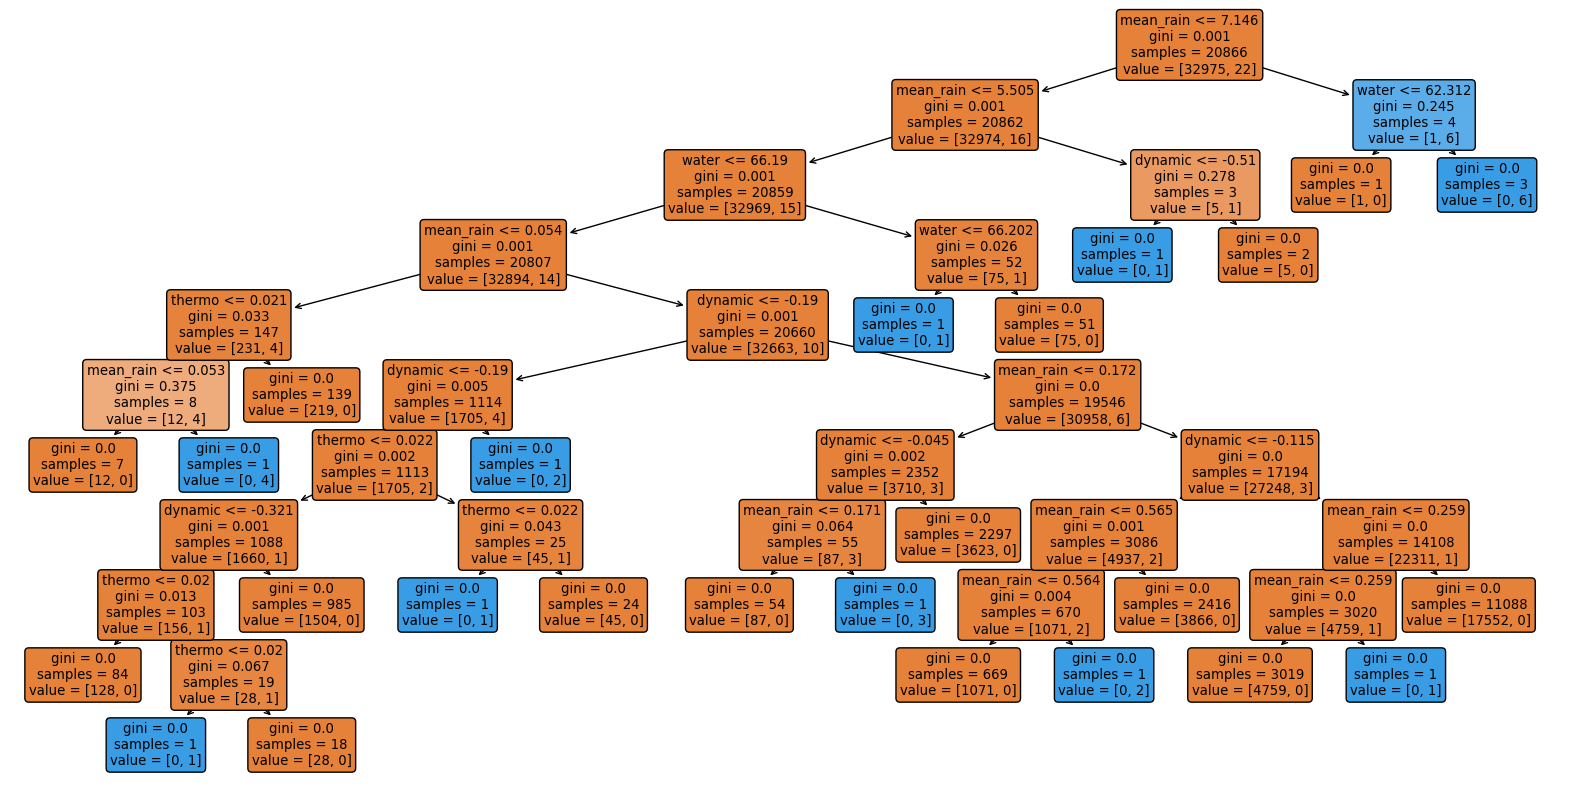

In [63]:
from sklearn.tree import plot_tree
%matplotlib inline 

# Visualize one of the trees in the forest
plt.figure(figsize=(20,10))
chosen_tree = clf_mean_unweighted.estimators_[0]  # Just as an example, choose the first tree
plot_tree(chosen_tree, filled=True, feature_names=feature_names, rounded=True)
plt.show()


In [64]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_mean_unweighted)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])


## let's try with a single tree

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split the data for 'cond_alpha_50_Prec_label'
X_train, X_test, y_train, y_test = train_test_split(data[['dynamic', 'thermo', 'water', 'mean_rain']], data['cond_alpha_50_Prec_label'], test_size=0.2, random_state=42)

# Train a classifier using a single decision tree
clf_decision_tree = DecisionTreeClassifier(random_state=42)
clf_decision_tree.fit(X_train, y_train)

# Evaluate the classifier
accuracy_decision_tree = clf_decision_tree.score(X_test, y_test)
print(f"Model accuracy for 'cond_alpha_50_Prec_label': {accuracy_decision_tree*100:.2f}%")

# Calculate and print feature importances
importances = clf_decision_tree.feature_importances_
feature_names = ['dynamic', 'thermo', 'water', 'mean_rain']
feature_importance_dict = dict(zip(feature_names, importances))
print(feature_importance_dict)


Model accuracy for 'cond_alpha_50_Prec_label': 86.45%
{'dynamic': 0.23706176808671692, 'thermo': 0.283615741275036, 'water': 0.2233767823138505, 'mean_rain': 0.25594570832439656}
